# To visualize approaches

A simulated dataset is made to vizualize the filtering performed by the clustering approaches and the 

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))

sys.path.insert(1, module_path + '/src')
import utility

sys.path.insert(1, module_path + '/src/models')
import bootstrapped_ensemble_cluster_filter as BE_cluster_filter


from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


import pprint
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 11, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)

figure_path = module_path + '/figures/cluster_filter/'

def scatterplot_with_colors(X, y):
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
    colors = ['#F94144', '#90BE6D', '#577590','#F3722C', '#F8961E', '#F9844A', '#F9C74F', '#43AA8B', '#4D908E', '#277DA1']
    colorsDict = {idx : color for (idx, color) in enumerate(colors)}
    colorsDict[-1] = '#484848'
    f, ax = plt.subplots(1,1) # 1 x 1 array , can also be any other size
    f.set_size_inches(5, 5)
    grouped = df.groupby('label')
    for key, group in grouped:
        label_key = key
        if key == -1:
            label_key = 'deleted samples'
        ax = group.plot(ax=ax, kind='scatter', x='x', y='y',
                        label=label_key, color=colorsDict[key] ,
                        s = 7, alpha=0.8)


    for label in ax.get_ylabel() :
        ax.set_ylabel(label, fontproperties = font)
    for label in ax.get_xlabel() :
        ax.set_xlabel(label, fontproperties = font)
    for label in ax.get_yticklabels() :
        label.set_fontproperties(font)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(font)
    ax.legend(prop=font)
    
    return f

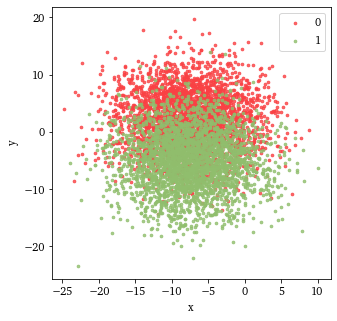

In [2]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=6000, centers=2, n_features=2, cluster_std = 5, random_state = 43)
# scatter plot, dots colored by class value

X, y = pd.DataFrame(X), pd.Series(y)

y = y.astype(int)
X.columns = np.arange(len(X.columns))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = X_train.reset_index(drop = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

y_train = y_train.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

f = scatterplot_with_colors(X.values, y.values)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


k_range = list(range(1,8))
cluster_range = list(range(10,15))
thresh_range = [6]

# Thresh should only be 6 or higher -> means that two ensembles have voted for this cluster as the worst one
weight_options = ["uniform", "distance"]
grid = dict(n_neighbors = k_range, weights = weight_options)

clf = KNeighborsClassifier()

clf_dict = {
    'knn': KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1),
    'knnOptimal': clf,
    'nb': GaussianNB()
}

grid_dict = {
    'knnOptimal': grid
}

param_dict = BE_cluster_filter.hyperparam_search(X_train, y_train, X_val, y_val,
                                   clf_dict, grid_dict = grid_dict,
                                   clusters_list = cluster_range,
                                  thresh_list = thresh_range)

pprint.pprint(param_dict, depth = 2)

{'knn': {'custers': 13,
         'keep clusters': array([ 0,  1,  2,  4,  5,  6,  7,  8, 11, 12]),
         'threshold': 6},
 'knnOptimal': {'custers': 13,
                'keep clusters': array([ 0,  1,  3,  4,  5,  7,  8, 10, 11, 12]),
                'threshold': 6},
 'nb': {'custers': 14,
        'keep clusters': array([ 1,  3,  4,  5,  6,  7,  8, 10, 11, 12]),
        'threshold': 6}}


### Plotting performance filtering on validation set

Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]


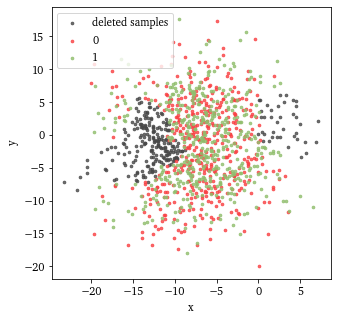

{'knn': {'filtered': 0.6831578947368421, 'original': 0.66},
 'knnOptimal': {'filtered': 0.725, 'original': 0.74},
 'nb': {'filtered': 0.7583046964490263, 'original': 0.7558333333333334}}


In [5]:
_, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train, y_train, X_val, y_val, clf_dict,
                                     param_dict = param_dict)

acc_dict = BE_cluster_filter.get_results_dict(X_train, y_train, X_val, y_val, clf_dict, indices)


mask=np.full(len(y_val),True,dtype=bool)
mask[indices['knn']]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = scatterplot_with_colors(X_val.values, new_y_test.values)
plt.show()

pprint.pprint(acc_dict)

### Test set filtering

Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
{'knn': {'filtered': 0.7033195020746889, 'original': 0.6833333333333333},
 'knnOptimal': {'filtered': 0.731203007518797, 'original': 0.7466666666666667},
 'nb': {'filtered': 0.7690504103165299, 'original': 0.76}}


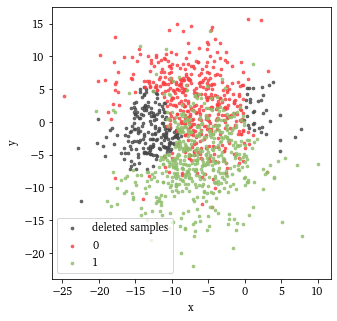

In [6]:
_, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train, y_train, X_test, y_test, clf_dict,
                                     param_dict = param_dict)


acc_dict = BE_cluster_filter.get_results_dict(X_train, y_train, X_test, y_test, clf_dict, indices)
name = 'knn'

mask=np.full(len(y_test),True,dtype=bool)
mask[indices[name]]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = scatterplot_with_colors(X_test.values, new_y_test.values)
f.savefig(figure_path + 'simulated_data_cluster_filtered.pdf', bbox_inches='tight')

pprint.pprint(acc_dict)

plt.show()

# Adding noise

In [7]:
new_X, n_idx= BE_cluster_filter.add_noise_dataset(X_test, 20, 3)

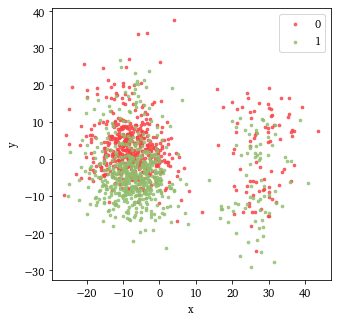

In [8]:
scatterplot_with_colors(new_X.values, y_test.values)

f.savefig(figure_path + 'simulated_data_with_noise_cluster_not_filtered.pdf', bbox_inches='tight')

Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
{'knn': {'filtered': 0.6706135629709364, 'original': 0.6458333333333334},
 'knnOptimal': {'filtered': 0.707395498392283, 'original': 0.6991666666666667},
 'nb': {'filtered': 0.7290076335877863, 'original': 0.7025}}


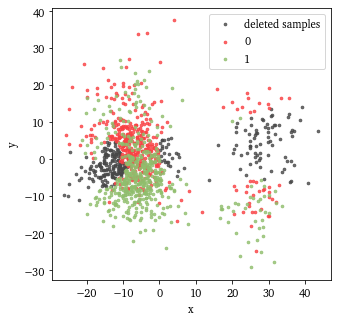

In [9]:
_, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train, y_train, new_X, y_test, clf_dict, param_dict = param_dict)
acc_dict = BE_cluster_filter.get_results_dict(X_train, y_train, new_X, y_test, clf_dict, indices)


name = 'knn'
mask=np.full(len(new_X),True,dtype=bool)
mask[indices[name]]=False

new_y_test = y_test.copy()
new_y_test.iloc[mask] = -1

f = scatterplot_with_colors(new_X.values, new_y_test.values)

f.savefig(figure_path + 'simulated_data_with_noise_cluster_filtered.pdf', bbox_inches='tight')

pprint.pprint(acc_dict)

# Gradually adding more noise

In [10]:
ampl_list = [5, 10, 15, 18, 22, 26]
result_dict = {}


for ampl in ampl_list:
    new_X, n_idx= BE_cluster_filter.add_noise_dataset(X_test, ampl, 4)
    
    _, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    acc_dict = BE_cluster_filter.get_results_dict(X_train, y_train, new_X, y_test, clf_dict, indices)
    
    
    result_dict[ampl] = acc_dict
pprint.pprint(result_dict, depth = 3)

Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
{5: {'knn': {'filtered': 0.6956521739130435, 'original': 0.6716666666666666},
     'knnOptimal': {'filtered': 0.719488188976378, 'original': 0.735},
     

In [11]:
amount_list = [12, 7, 5, 4, 3, 2] # Is invertly large --> 3 means more noise is added than 4
result_dict = {}


for am in amount_list:
    new_X, n_idx= BE_cluster_filter.add_noise_dataset(X_test, 15, am)
    
    _, indices = BE_cluster_filter.bootstrapped_ensemble_cluster_filter(X_train,y_train, new_X, y_test, clf_dict, param_dict = param_dict)

    acc_dict = BE_cluster_filter.get_results_dict(X_train, y_train, new_X, y_test, clf_dict, indices)
    
    
    result_dict[am] = acc_dict
pprint.pprint(result_dict, depth = 3)

Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
Keep clusters: [ 0  1  2  4  5  6  7  8 11 12]
Keep clusters: [ 0  1  3  4  5  7  8 10 11 12]
Keep clusters: [ 1  3  4  5  6  7  8 10 11 12]
{2: {'knn': {'filtered': 0.6622950819672131, 'original': 0.6391666666666667},
     'knnOptimal': {'filtered': 0.6939704209328783,
                    'ori